In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import os
import sys

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer
import xgboost as xgb

%matplotlib inline

In [2]:
class XGBoost_model():
    def __init__(self, **kwargs):
        self.objective = kwargs.get('objective', 'reg:squarederror')
        self.learning_rate = kwargs.get('learning_rate', 0.15)
        self.subsample = kwargs.get('subsample', 1.0)
        self.max_depth = kwargs.get('max_depth', 3)
        self.n_estimators = kwargs.get('n_estimators', 150)
        self.booster = kwargs.get('booster', 'gbtree')
        self.gamma = kwargs.get('gamma', 0)
        self.reg_alpha = kwargs.get('reg_alpha', 0)
        self.reg_lambda = kwargs.get('reg_lambda', 1)
        
        self.model = None

    def opt_hyper_grid(self, x, y, param_space, num_sets: int=10):

        print('Finding best hyper-parameters for the model...')
        estimator = xgb.XGBRegressor(objective=self.objective, max_depth=self.max_depth,
                                     learning_rate=self.learning_rate, n_estimators=self.n_estimators,
                                     subsample=self.subsample, booster=self.booster, n_jobs=-1, gamma=self.gamma,
                                     reg_alpha=self.reg_alpha, reg_lambda=self.reg_lambda)
        xgb_try = GridSearchCV(estimator=estimator, param_grid=param_space, 
                               cv=KFold(n_splits=num_sets, shuffle=False), 
                               scoring='neg_mean_absolute_error')
        grid_result = xgb_try.fit(x, y)

        means = grid_result.cv_results_['mean_test_score']
        params = grid_result.cv_results_['params']
        
        for mean, param in zip(means, params):
            print("%f  with:   %r" % (mean, param))

        best_params = xgb_try.best_params_
        print('Best params set:', best_params)
        print('Minimum mean absolute error:', -np.max(means))
        print('---------------------------------------------------')
        
        self.learning_rate = best_params.get('learning_rate', self.learning_rate)
        self.max_depth = best_params.get('max_depth', self.max_depth)
        self.subsample = best_params.get('subsample', self.subsample)
        self.n_estimators = best_params.get('n_estimators', self.n_estimators)
        self.booster = best_params.get('booster', self.booster)
        self.gamma = best_params.get('gamma', self.gamma)
        self.reg_alpha = best_params.get('reg_alpha', self.reg_alpha)
        self.reg_lambda = best_params.get('alpha', self.reg_lambda)


    def build_model(self, x, y, params, grid_search: bool = True):
        """
        If use grid search, then each parameter can have multiple values
        
        Example: params = {'learning_rate': [0.1, 0.3],
                           'n_estimators': [100, 200, 300]
                           }
                           
        If do not use grid search, then each parameter should have only one value
        
        Example: params = {'learning_rate': 0.1,
                           'n_estimators': 100
                          }
        
        """
        
        
        if grid_search:
            self.opt_hyper_grid(x, y, params)
        else:

            self.learning_rate = params.get('learning_rate', self.learning_rate)
            self.max_depth = params.get('max_depth', self.max_depth)
            self.subsample = params.get('subsample', self.subsample)
            self.n_estimators = params.get('n_estimators', self.n_estimators)
            self.booster = params.get('booster', self.booster)
            self.gamma = params.get('gamma', self.gamma)
            self.reg_alpha = params.get('reg_alpha', self.reg_alpha)
            self.reg_lambda = params.get('alpha', self.reg_lambda)

        xgb_reg = xgb.XGBRegressor(objective=self.objective, max_depth=self.max_depth,
                                   learning_rate=self.learning_rate, n_estimators=self.n_estimators,
                                   subsample=self.subsample, booster=self.booster, gamma=self.gamma,
                                   n_jobs=-1, reg_alpha=self.reg_alpha, reg_lambda=self.reg_lambda)
        # 10 fold cross validation
        sk = KFold(n_splits=10, shuffle=False)
        scores_train = list()
        scores_val = list()
        for train_ind, val_ind in sk.split(x, y):
            train_x = x.iloc[train_ind].values
            train_y = y.iloc[train_ind]
            val_x = x.iloc[val_ind].values
            val_y = y.iloc[val_ind]

            xgb_reg.fit(train_x, train_y)
            pred_train_xgb = xgb_reg.predict(train_x)
            pred_val_xgb = xgb_reg.predict(val_x)

            score_train = mean_absolute_error(train_y, pred_train_xgb)
            scores_train.append(score_train)
            score_val = mean_absolute_error(val_y, pred_val_xgb)
            scores_val.append(score_val)

        print('Train mean absolute error:', np.mean(scores_train))
        print('Val mean absolute error:', np.mean(scores_val))
        print("Train score: ", scores_train)
        print("Validation score: ", scores_val)
        
        self.model = xgb_reg

        return xgb_reg, scores_train, scores_val

    
    def save_model(self, model_path):
        print('Saving model...')
        joblib.dump(self.model, model_path)
        print('Model saved.')


    def predict_with_model(self, x_test):
        y_test_pred = self.model.predict(x_test)
        return y_test_pred

In [3]:
# Load the data
BTC_BUSD = pd.read_csv("../Data/BTC2.csv")

In [4]:
# Check if there is any NaN values
for col_name, _ in BTC_BUSD.iteritems():
    if len(BTC_BUSD[BTC_BUSD[col_name].isna()])>0:
        print("%s: %s rows" % (col_name, len(BTC_BUSD[BTC_BUSD[col_name].isna()])))

Text(0, 0.5, 'BTC-BUSD close price')

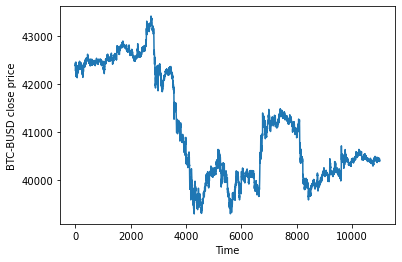

In [5]:
# Show the plot
plt.plot(BTC_BUSD['close'])
plt.xlabel('Time')
plt.ylabel('BTC-BUSD close price')

In [6]:
# Option 1: Use all features
BTC_BUSD_copy = BTC_BUSD.copy()
BTC_BUSD_copy.reset_index(drop=True, inplace=True)
BTC_BUSD_copy.head()

,open_time,avg,wgtavg,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2022-04-08 22:33:00,0.106600,-0.076148,42409.00,42409.01,42367.01,42384.64,3.75072,158990.77,254,1.41116,59816.070
1,2022-04-08 22:34:00,0.228277,0.047320,42384.63,42387.50,42344.08,42373.66,5.21452,220892.70,229,1.48407,62871.580
2,2022-04-08 22:35:00,0.142080,0.078871,42369.76,42424.41,42369.75,42415.69,5.10597,216482.45,213,3.03908,128832.950
3,2022-04-08 22:36:00,0.207449,0.232077,42415.68,42453.85,42415.42,42439.52,5.04461,214064.31,252,3.75288,159234.840
4,2022-04-08 22:37:00,0.163528,0.358569,42439.51,42451.54,42412.62,42415.94,2.93812,124666.83,162,0.69743,29594.648


In [7]:
# Determine if grid search is necessary
grid_search = False

# Determine if we want to save the new trained models
save_model = True

    
# Set predict time (e.g. m=5 represents "5 minutes later")
for m in range(1, 6):
    
    print("Start build model to predcit price %d minutes later........." % (m))
    
    # Set target predict price (m minutes later)
    target_price = BTC_BUSD_copy['close'].shift(-m, fill_value=BTC_BUSD_copy['close'].iloc[-1]).rename("price_m_min_later")
    target_price_diff = (target_price - BTC_BUSD_copy['close']).rename("price_diff_m_min_later")
    # Get dataset
    dataset = pd.concat([BTC_BUSD_copy, target_price, target_price_diff], axis=1)
    


    # Determine if we want to predict price difference
    diff = True

    if diff:
        X_train = dataset.iloc[:, 1:-2]

        # Use price difference as the target
        Y_train = dataset.iloc[:, -1]

    else:
        X_train = dataset.iloc[:, 1:-2]

        # Use future price as the target
        Y_train = dataset.iloc[:, -2]





    # With hyperparameter grid search
    if grid_search:
        task = XGBoost_model()

        params = {'learning_rate': [0.03, 0.1, 0.3],
                   'n_estimators': [100, 200, 300]

        }

        xgb_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=True)
#         Y_test_pred = task.predict_with_model(X_test)
#         print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

    # Without hyperparameter grid search
    else:
        task = XGBoost_model()

        params = {'learning_rate': 0.1,
                   'n_estimators': 200

        }

        xgb_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=False)
#         Y_test_pred = task.predict_with_model(X_test)
#         print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

    # Save model
    if save_model:

        save_path = "Models/xgboost_ns_" + str(m) + "_minutes_later.pkl"
        task.save_model(save_path)

    print("=" * 50)



Start build model to predcit price 1 minutes later.........
Train mean absolute error: 16.505716274220724
Val mean absolute error: 18.03083751752815
Train score:  [16.832472112685622, 17.40549107977507, 16.337149119059283, 15.56460161598095, 16.003271670578492, 16.198611243748495, 16.180066972366536, 16.402684424206832, 16.71351548430403, 17.41929901950189]
Validation score:  [14.45703556728824, 9.322131346084346, 19.290723767711224, 27.56452880267288, 22.990897645156366, 21.822215270940493, 20.79012593043402, 18.863583940367157, 15.685234777560096, 9.521898127066697]
Saving model...
Model saved.
Start build model to predcit price 2 minutes later.........
Train mean absolute error: 23.563259455324836
Val mean absolute error: 25.89047406751227
Train score:  [23.964666061777326, 24.816007746362967, 23.276091080531756, 22.098533825641326, 22.80926537266613, 23.17760222411082, 23.159626127743966, 23.425905885067955, 23.94678852914166, 24.958107700204454]
Validation score:  [21.311607469155

In [8]:
xgboost_models = []
m_min, m_max = 1, 5
for m in range(m_min, m_max+1):
    load_path = "Models/xgboost_ns_" + str(m) + "_minutes_later.pkl"
    if os.path.exists(load_path):
        xgboost_models.append(joblib.load(load_path))
    else:
        print("Warning: model %d does not found." % (m))

In [9]:
# Evaluate validation set performance of each fold in cross-validation
N = len(BTC_BUSD_copy)
s_points = np.linspace(0, N, 11, dtype=int)

mae_error_list, mape_error_list = [], []
for i in range(len(s_points)-1):
    st_point = s_points[i]
    weights = [(m-i)/np.sum(np.arange(m+1)) for i in range(m)]
    pred_length = s_points[i+1] - s_points[i]
    price_pred = []
    for i in range(pred_length):
        cur_sum = 0
        cur_portion = 0
        for j in range(m):
            if st_point-((j+m)-i) < st_point + pred_length:
                cur_sum += weights[j] * (xgboost_models[j].predict(BTC_BUSD_copy.iloc[st_point-((j+m)-i), 1:].values.reshape(1,-1)) + BTC_BUSD_copy.iloc[st_point-((j+m)-i)]['close'])[0]
                cur_portion += weights[j]
        price_pred.append(cur_sum / cur_portion if cur_portion !=0 else 0)

    price_true = BTC_BUSD_copy.iloc[st_point:st_point+pred_length]['close'].values
    mae_error_list.append(mean_absolute_error(price_true, price_pred))
    mape_error_list.append(mean_absolute_percentage_error(price_true, price_pred))
print("MAE: ", mae_error_list)
print("MAPE: ", mape_error_list)

MAE:  [44.04643844696987, 24.16025677083332, 45.36919403409064, 63.872741761363514, 51.539904498106026, 47.643412689393834, 46.511246164772764, 42.990884138257684, 35.168041666666625, 20.011457529140227]
MAPE:  [0.001038969666766616, 0.0005666553126282624, 0.0010662883628594802, 0.0015707120699649038, 0.0012877849369702676, 0.001194733469743327, 0.0011343943853986292, 0.0010641887781759373, 0.0008736831369520302, 0.0004947189182156036]


In [10]:
print("Mean MAE: ", np.average(mae_error_list))
print("Man MAPE: ", np.average(mape_error_list))

Mean MAE:  42.13135776995945
Man MAPE:  0.0010292129037675055


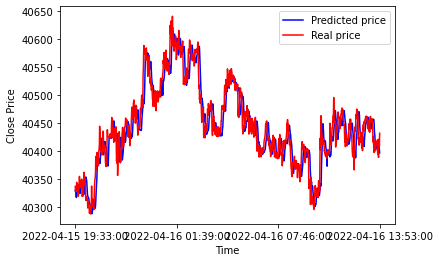

In [11]:
# %matplotlib
plt.plot(BTC_BUSD_copy.iloc[st_point:st_point+pred_length]['open_time'], price_pred,'b', label='Predicted price')
plt.plot(BTC_BUSD_copy.iloc[st_point:st_point+pred_length]['open_time'], price_true, 'r', label="Real price")
plt.legend()
plt.xlabel("Time")
plt.xticks([BTC_BUSD_copy.iloc[i]['open_time'] for i in np.linspace(st_point, st_point+pred_length-1, 4, dtype=int)])
plt.ylabel("Close Price")
plt.show()

# Do not use Twitter Data

In [12]:
# Option 2: Do not use twitter information
BTC_BUSD_copy2 = BTC_BUSD.copy().drop(labels=['avg','wgtavg'],axis=1)
BTC_BUSD_copy2.reset_index(drop=True, inplace=True)
BTC_BUSD_copy2.head()

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2022-04-08 22:33:00,42409.00,42409.01,42367.01,42384.64,3.75072,158990.77,254,1.41116,59816.070
1,2022-04-08 22:34:00,42384.63,42387.50,42344.08,42373.66,5.21452,220892.70,229,1.48407,62871.580
2,2022-04-08 22:35:00,42369.76,42424.41,42369.75,42415.69,5.10597,216482.45,213,3.03908,128832.950
3,2022-04-08 22:36:00,42415.68,42453.85,42415.42,42439.52,5.04461,214064.31,252,3.75288,159234.840
4,2022-04-08 22:37:00,42439.51,42451.54,42412.62,42415.94,2.93812,124666.83,162,0.69743,29594.648


In [13]:
# Determine if grid search is necessary
grid_search = False

# Determine if we want to save the new trained models
save_model = True

    
# Set predict time (e.g. m=5 represents "5 minutes later")
for m in range(1, 6):
    
    print("Start build model to predcit price %d minutes later........." % (m))
    
    # Set target predict price (m minutes later)
    target_price = BTC_BUSD_copy2['close'].shift(-m, fill_value=BTC_BUSD_copy2['close'].iloc[-1]).rename("price_m_min_later")
    target_price_diff = (target_price - BTC_BUSD_copy2['close']).rename("price_diff_m_min_later")
    # Get dataset
    dataset = pd.concat([BTC_BUSD_copy2, target_price, target_price_diff], axis=1)
    


    # Determine if we want to predict price difference
    diff = True

    if diff:
        X_train = dataset.iloc[:, 1:-2]

        # Use price difference as the target
        Y_train = dataset.iloc[:, -1]

    else:
        X_train = dataset.iloc[:, 1:-2]

        # Use future price as the target
        Y_train = dataset.iloc[:, -2]





    # With hyperparameter grid search
    if grid_search:
        task = XGBoost_model()

        params = {'learning_rate': [0.03, 0.1, 0.3],
                   'n_estimators': [100, 200, 300]

        }

        xgb_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=True)
#         Y_test_pred = task.predict_with_model(X_test)
#         print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

    # Without hyperparameter grid search
    else:
        task = XGBoost_model()

        params = {'learning_rate': 0.1,
                   'n_estimators': 200

        }

        xgb_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=False)
#         Y_test_pred = task.predict_with_model(X_test)
#         print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

    # Save model
    if save_model:

        save_path = "Models/xgboost_ns_" + str(m) + "_minutes_later_no_twitter_try.pkl"
        task.save_model(save_path)

    print("=" * 50)



Start build model to predcit price 1 minutes later.........
Train mean absolute error: 16.584890456904443
Val mean absolute error: 17.961518341652233
Train score:  [16.908192662535196, 17.492159253165422, 16.43486618593215, 15.58784068768926, 16.052698771612487, 16.305312040489756, 16.285609091290613, 16.4690648337616, 16.797834969825253, 17.51532607274267]
Validation score:  [14.441389266437909, 9.297705306932428, 19.441809417358613, 27.72776648353915, 23.009436565169597, 20.85006224497683, 20.861902850078742, 18.82318928030705, 15.638654780235017, 9.523267221487]
Saving model...
Model saved.
Start build model to predcit price 2 minutes later.........
Train mean absolute error: 23.646872152510152
Val mean absolute error: 25.806177259940306
Train score:  [24.100247111599444, 24.91861735684681, 23.33232888295603, 22.15853580599241, 22.92714139098709, 23.18566842575435, 23.268816434469695, 23.47629398432664, 24.046043399298277, 25.055028732870777]
Validation score:  [21.186901008738456, 

In [14]:
xgboost_models = []
m_min, m_max = 1, 5
for m in range(m_min, m_max+1):
    load_path = "Models/xgboost_ns_" + str(m) + "_minutes_later_no_twitter_try.pkl"
    if os.path.exists(load_path):
        xgboost_models.append(joblib.load(load_path))
    else:
        print("Warning: model %d does not found." % (m))

In [15]:
N = len(BTC_BUSD_copy2)
s_points = np.linspace(0, N, 11, dtype=int)

mae_error_list, mape_error_list = [], []
for i in range(len(s_points)-1):
    st_point = s_points[i]
    weights = [(m-i)/np.sum(np.arange(m+1)) for i in range(m)]
    pred_length = s_points[i+1] - s_points[i]
    price_pred2 = []
    for i in range(pred_length):
        cur_sum = 0
        cur_portion = 0
        for j in range(m):
            if st_point-((j+m)-i) < st_point + pred_length:
                cur_sum += weights[j] * (xgboost_models[j].predict(BTC_BUSD_copy2.iloc[st_point-((j+m)-i), 1:].values.reshape(1,-1)) + BTC_BUSD_copy2.iloc[st_point-((j+m)-i)]['close'])[0]
                cur_portion += weights[j]
        price_pred2.append(cur_sum / cur_portion if cur_portion !=0 else 0)

    price_true = BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['close'].values
    mae_error_list.append(mean_absolute_error(price_true, price_pred2))
    mape_error_list.append(mean_absolute_percentage_error(price_true, price_pred2))
print("MAE: ", mae_error_list)
print("MAPE: ", mape_error_list)

MAE:  [44.128261695075786, 24.26851960227278, 45.436624526515025, 63.82903892045436, 51.448549005681784, 48.28423134469676, 46.534283285984635, 43.077704971590855, 35.112874005681824, 20.04042570201324]
MAPE:  [0.0010408995024290043, 0.0005691953696080864, 0.0010679245647732584, 0.001569584854169643, 0.0012854948916922132, 0.0012107563967273544, 0.001134986935535302, 0.00106639908592169, 0.0008723057261593947, 0.0004954268285715365]


In [16]:
print("Mean MAE: ", np.average(mae_error_list))
print("Man MAPE: ", np.average(mape_error_list))

Mean MAE:  42.2160513059967
Man MAPE:  0.0010312974155587482


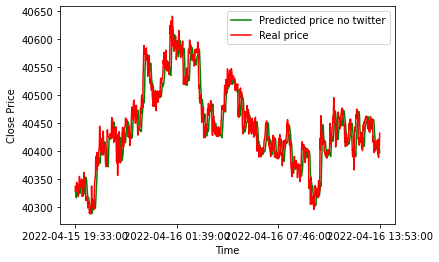

In [17]:
plt.plot(BTC_BUSD_copy.iloc[st_point:st_point+pred_length]['open_time'], price_pred2,'g', label='Predicted price no twitter')
plt.plot(BTC_BUSD_copy.iloc[st_point:st_point+pred_length]['open_time'], price_true, 'r', label="Real price")

plt.legend()
plt.xlabel("Time")
plt.xticks([BTC_BUSD_copy.iloc[i]['open_time'] for i in np.linspace(st_point, st_point+pred_length-1, 4, dtype=int)])
plt.ylabel("Close Price")
plt.show()